In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import simulate_gbm

In [12]:
def mean_diff(S0, mu, sigma, T, N, n_paths, leverage):
    return simulate_gbm(S0, mu, sigma, T, int(N), n_paths, leverage).mean()


In [2]:
def std_diff(S0, mu, sigma, T, N, n_paths, leverage):
    return simulate_gbm(S0, mu, sigma, T, int(N), n_paths, leverage).std()

In [58]:
def plot_heat_lev_sigma_std(
    mu = 0,
    sigmas=np.linspace(0.01,0.4,100),
    T = 5,
    freq=1,
    n_paths=10000,
    factors = np.linspace(1.01,3,100)
):
    factor, sigma = np.meshgrid(factors, sigmas)

    diff = np.log(np.vectorize(std_diff)(1, mu, sigma, T, T * freq, n_paths, factor))

    plt.figure(figsize = (4,3))
    plt.contourf(factor,sigma, diff, cmap="coolwarm")
    plt.title("log of standard deviation of percentage difference lETF - underlying")
    plt.xlabel("leverage factor")
    plt.ylabel("sigma")
    plt.colorbar()

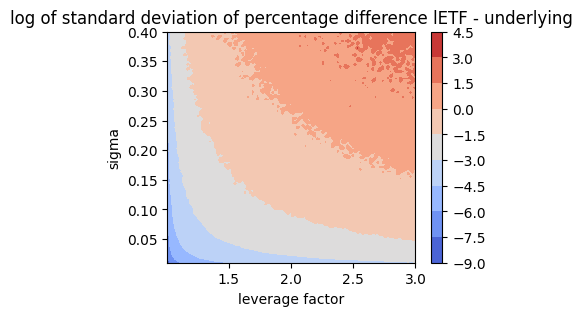

In [11]:
plot_heat_lev_sigma_std()

In [17]:
def plot_heat_lev_sigma_mean(
    mu = 0,
    sigmas=np.linspace(0.01,0.4,100),
    T = 5,
    freq=1,
    n_paths=1000,
    factors = np.linspace(1.01,3,100)
):
    factor, sigma = np.meshgrid(factors, sigmas)

    diff = np.vectorize(mean_diff)(1, mu, sigma, T, T * freq, n_paths, factor)

    plt.figure(figsize = (4,3))
    plt.contourf(factor,sigma, diff, cmap="coolwarm")
    plt.title("mean of percentage difference lETF - underlying")
    plt.xlabel("leverage factor")
    plt.ylabel("sigma")
    plt.colorbar()

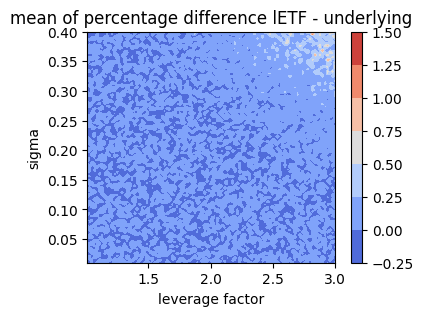

In [18]:
plot_heat_lev_sigma_mean()

In [19]:
from mpl_toolkits.mplot3d import Axes3D

In [66]:


def plot_surface_lev_sigma_std(
    mu = 0,
    sigmas=np.linspace(0.01,0.4,100),
    T = 5,
    freq=1,
    n_paths=50000,
    factors = np.linspace(1.01,3,100)
):
    factor, sigma = np.meshgrid(factors, sigmas)

    diff = np.vectorize(std_diff)(1, mu, sigma, T, T * freq, n_paths, factor)

    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(
        factor,
        sigma,
        diff,
        cmap="coolwarm",
        linewidth=0,
        antialiased=True
    )

    ax.set_title("log std of percentage difference lETF - underlying")
    ax.set_xlabel("leverage factor")
    ax.set_ylabel("sigma")
    ax.set_zlabel("log std diff")

    fig.colorbar(surf, shrink=0.6, aspect=10)
    

    #ax.view_init(elev=25, azim=190)
    
    plt.show()


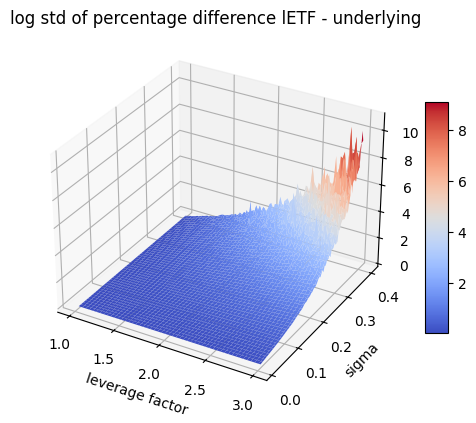

In [67]:
plot_surface_lev_sigma_std()